### DNNスクラッチコード

### DNNとは

DeepNeuralNetwork(DNN)とはニューラルネットワークを文字通りdeepに(深く)したものです。
ニューラルネットワークが３層（入力層、隠れ層、出力層）だったのに対し、DNNは隠れ層が４つ以上のものを指します。

非線形関数を組み合わせることで表現力を高めることが

また層を深くすることでメリットだけでなく**勾配爆発/消失、過学習**といった問題が発生する恐れもあります。

- 勾配爆発

- 勾配消失
    - バックプロパゲーションで勾配を求める際を考える。計算グラフで乗算ノードとなる層（全結合層、畳み込み層など）が複数層ある場合、勾配の値は基本的に-1から1の間の値を取るため前の層に行くほど小さくなってしまう。つまり前の層ほど学習スピードが遅くなってしまう。

- 過学習
    - 層を深くすることで表現力が増すため、学習データに対する精度はどんどん上がっていきます。これが行き過ぎると学習データに最適化されすぎて未学習のデータに対する精度が下がってしまう。このように特定のデータにだけ性能が高く、汎化性能が落ちることを**過学習**と呼びます。
    
    
DNNを構築する際は上記のような問題に対処できるような工夫（ReLUを使う、正則化項）や機能層（ドロップアウト、バッチノーマリゼーション）を採用する必要がります。

### データのロード

mnistの手書き文字認識問題

784ピクセルの値（0-255）から数字（0-9）を分類する。

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas as pd

%matplotlib inline

train_df = pd.read_csv("train.csv", nrows=1000)
# train_df = pd.read_csv("train.csv")
# test_df = pd.read_csv("test.csv", nrows=100)

X = train_df.drop('label', axis=1)
y = pd.get_dummies(train_df['label'])
X = np.array(X)
y = np.array(y)


# 訓練とテストデータに分割
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### 活性化関数を用意

シグモイド

ReLU

tanh

In [2]:
# def sigmoid(z):
#      return 1/(1+np.exp(-z))
    
# def ReLU(z):
#     a = z.copy()
#     a[a<0]=0
#     return a

### 出力関数　ソフトマックス関数

In [3]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)

### コスト関数

In [4]:
def cross_entropy_error(y, y_pred):
    
    data_size = y.shape[0]

    # クロスエントロピー誤差関数　y_predは０になりえるので -inf にならないためにすごく小さい補正値を入れる
    cross_entorpy = -np.sum(y * np.log(y_pred + 1e-7))
    
    error = cross_entorpy  / data_size
    return error

In [5]:
# def cost(y, y_pred, params, lam=0.01):
#     data_size = y.shape[0]
#     #  正則化項
#     weight_sum = sum([np.sum(matrix**2) for key, matrix in params.items() if "W" in key])
#     reg_term = (lam /2) * (weight_sum)
#     # クロスエントロピー誤差関数　y_predは０になりえるので -inf にならないためにすごく小さい補正値を入れる
#     cross_entorpy = -np.sum(y * np.log(y_pred + 1e-7))
    
#     cost = (cross_entorpy + reg_term) / data_size
#     return cost

### 正答率を算出する関数

In [6]:
# # 正答率を算出する
# def accuracy_score(X, y, params):
#     y_pred =  predict(X, params)
#     y_pred_number = np.argmax(y_pred, axis=1)
    
#     y_label = np.argmax(y, axis=1)
    
#     data_size = X.shape[0]
    
#     correct_count = np.sum([y_label == y_pred_number]) 
#     score = correct_count / data_size * 100
    
#     return round(score, 2)

In [7]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 損失関数
        self.y = None       # softmaxの出力
        self.t = None       # 教師データ（one-hot vector)
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size # delta3に相当
        
        return dx

### アフィン変換層

更新手法をsgd,adagrad,adamと切り替えられる。

In [1]:
class Affine:
    def __init__(self, W, b, params= {'optimizer': 'sgd', 'lr': 0.01}):
        self.W = W
        self.b = b
        self.x = None
        # パラメータの微分値
        self.dW = None
        self.db = None
        
        # optimizerのスイッチング
        # optimizeメソッドを付け替える
        if params['optimizer']=='sgd':
            self.optimize = self.update_sgd
        elif params['optimizer'] == 'adagrad':
            self.h = np.zeros_like(W)
            self.optimize = self.update_adagrad
        else: # params['optimizer'] == 'adam':
            self.m = np.zeros_like(W)
            self.v = np.zeros_like(W)
            self.beta1 = 0.9
            self.beta2 = 0.999
            self.optimize = self.update_adam
        
    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b

        return out
    
    def backward(self, dout=1):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        return dx
    
    def update_sgd(self):
        self.W -= self.lr * self.dW
        self.b -= self.lr * self.db
    
    # adagrad 少しずつ更新量が減っていく
    def update_adagrad(self):
        self.h += self.dW ** 2
        self.W -= self.lr * self.dW / (np.sqrt(self.h) + 1e-7)
        self.b -= self.lr * self.db
        
    
    def update_adam(self):
        self.m = self.beta1 * self.m + (1- self.beta1) * self.dW
        self.v = self.beta2 * self.v + (1- self.beta2) * (self.dW * self.dW)
        
        m_hat = self.m / (1 - self.beta1)
        v_hat = self.v / (1 - self.beta2)
        
        self.W -= self.lr * m_hat / (np.sqrt(v_hat) + 1e-8)
        self.b -= self.lr * self.db
        

### 活性化関数層

活性化関数層には以前作成したReLU、tanh,シグモイド関数を切り替えて使用できる。

In [2]:
class Activation:
    '''
    活性化関数を設定できる 
    'tanh'
    'sigmoid'
    'relu'
    '''
    def __init__(self, params):
        self.out = None
        self.mask = None
        if params['act_func']=='tanh':
            self.forward = self.forward_tanh
            self.backward = self.backward_tanh
        elif params['act_func'] == 'sigmoid':
            self.forward = self.forward_sigmoid
            self.backward = self.backward_sigmoid
        else: # params['act_func'] == 'relu':
            self.forward = self.forward_relu
            self.backward = self.backward_relu
     
    def forward_relu(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        
        return out
    
    def backward_relu(self, dout):
        dout[self.mask] = 0
        dx = dout
        
        return dx

    # tanh 
    def forward_tanh(self, x):
        out = np.tanh(x)
        self.out = out
        
        return out
    
    def backward_tanh(self, dout):
        dx = dout * (1 - np.tanh(dout)**2)
        
        return dx
    
    # sigmoid関数
    def forward_sigmoid(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        
        return out
    
    def backward_sigmoid(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        
        return dx
        

### バッチノーマリゼーション層

Batch Normalization層とはフィーチャースケーリングを行うことで

効果として、

- 学習速度を早める
- 初期値にそれほど依存しない
- 過学習を抑制する

In [3]:
class BatchNorm:
    def __init__(self, lr=0.001):
        self.out = None
        self.beta = 0.0
        self.gamma = 1.0
        self.lr =lr
        self.eps = 1e-8
    
    '''
    計算式は下記を参照
    https://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html
    '''
    def forward(self, x):
        data_size, input_size = x.shape
        
        # 単に標準化する
        # out = (x - np.mean(x, axis=0)) / np.var()
        
        # step1: 平均を求める
        mu = np.mean(x, axis=0)
        
        # step2: 偏差
        self.xmu = x - mu
        
        # step3 : 偏差の２乗
        sq = self.xmu ** 2
        
        # step4 : 分散を求める
        self.var = np.var(x, axis=0)
        
        # step5 : 分散のルートを取った値を求める
        self.sqrtvar = np.sqrt(self.var + self.eps)
        
        # step6 : sqrtvarの逆数（invert）
        self.ivar = 1.0/ self.sqrtvar
        
        # step7 : 標準化した値
        self.xhat = self.xmu * self.ivar
        
        # step8
        gammax = self.gamma * self.xhat
        
        # step9
        out = gammax + self.beta
        
        return out

    
    def backward(self, dout=1):
        
        #get the dimensions of the input/output
        N, D = dout.shape
        
        # step9
        self.d_beta = np.sum(dout, axis=0)
        dgammax = dout #not necessary, but more understandable
        
        # step8
        self.d_gamma = np.sum(dgammax*self.xhat, axis=0)
        dxhat = self.d_gamma * self.gamma
        
        # step7
        divar = np.sum(dxhat*self.xmu, axis=0)
        dxmu1 = dxhat * self.ivar
        
        # step6
        dsqrtvar = -1. /(self.sqrtvar**2) * divar
        
        # step5
        dvar = 0.5 * 1. / np.sqrt(self.var+self.eps) * dsqrtvar
        
        # step4
        dsq = 1. / N * np.ones((N, D)) * dvar
        
        # step3
        dxmu2 = 2 * self.xmu * dsq
        
        # step2
        dx1 = (dxmu1 + dxmu2)
        dmu = -1 * np.sum(dxmu1 + dxmu2, axis=0)
        
        # step1
        dx2 = 1. / N * np.ones((N, D)) * dmu
        
        # step0
        dx = dx1 + dx2
        
        return dx

    
    def optimize(self):
        self.gamma -= self.lr * self.d_gamma
        self.beta -= self.lr * self.d_beta
        

### ドロップアウト層

In [11]:
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
    
    def forward(self, x, train_flg=True):
        if train_flg :
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1 - self.dropout_ratio)
    
    def backward(self, dout):
        return dout * self.mask

### 複数層を束ねるクラス(ネットワーククラス)

In [4]:
from collections import OrderedDict

class Layers:
    def __init__(self, params):
        unit_size_list = [params['input_size']]
        unit_size_list.extend(params['hidden_layer_list'])
        unit_size_list.append(params['output_size'])
        
        # レイヤの生成
        self.layers = OrderedDict()
        
        for i in range(1, len(unit_size_list)):
            # 重みの初期化
            init_W = np.random.randn(unit_size_list[i-1], unit_size_list[i])
            init_b = np.zeros([1, unit_size_list[i]])
            if params['init'] == 'gauss':
                init_W *= 0.01
            elif params['init'] == 'xavier':
                init_W /= np.sqrt(unit_size_list[i-1])
            else: # He
                init_W = init_W / np.sqrt(unit_size_list[i-1]) * np.sqrt(2) 
                
            # アフィン変換層（Wx + b）を追加する
            self.layers['Affine' + str(i)] = Affine(init_W, init_b, params)
            
            # 最終層以外はバッチノーマリゼーション層と活性化関数層を追加する
            if i < (len(unit_size_list)-1):
                if params['batch_norm'] == True:
                    self.layers['BatchNorm' + str(i)] = BatchNorm(0.001)
                self.layers['Active' + str(i)] = Activation(params)
        
        self.lastLayer = SoftmaxWithLoss()
        
        # self.params['hidden_layer_num'] = len(unit_size_list)-1
        
    def predict(self, x):
        # forwardを繰り返す
        # ソフトマックスを通さなくても答えは出るのでこれで予測とする 
        # argmaxでラベルを取れる
        for layer in self.layers.values():
            x =layer.forward(x)

        return x

    def accuracy(self, x, t):
        # 正答率を小数点第二桁で出力する
        y_pred = self.predict(x)
        y_pred = np.argmax(y_pred, axis=1)
        y_true = np.argmax(t, axis=1)
        data_size = x.shape[0]

        correct_count = np.sum([y_true == y_pred]) 
        score = correct_count / data_size * 100

        return round(score, 2)
    
    def loss(self, x, t):
        y = self.predict(x)
        
        return self.lastLayer.forward(y, t)
    
    # x:入力データ, t:教師データ
    ## 拝借コード
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.layers['Affine1'].W)
        grads['b1'] = numerical_gradient(loss_W, self.layers['Affine1'].b)
        grads['W2'] = numerical_gradient(loss_W, self.layers['Affine2'].W)
        grads['b2'] = numerical_gradient(loss_W, self.layers['Affine2'].b)
        
        print("Numerical: {}".format(grads['W1']) )
        print("OreOre   : {}".format(self.layers['Affine1'].W))
        
        return grads
    ### まだ使えていない
    
    
    def optimize(self, x, t):
        
        # forward 
        self.loss(x, t)
        
        # backward
        dout = self.lastLayer.backward(1)
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
            
        # optimizeメソッドがある層は更新を行う
        # AffineとBatchNorm層のみ行うはず
        for layer in self.layers.values():
            if hasattr(layer, "optimize"):
                layer.optimize()
            

In [14]:
from sklearn.model_selection import train_test_split


class DNN:
    def __init__(self, init='gauss', iteration = 500, lr = 0.05,
                 batch_mode = 'mini', act_func='relu',
                 batch_size_rate = 0.1, hidden_layer_list = [5], optimizer='sgd',
                 batch_norm=False, drop_out=False):
        """ ハイパーパラメータ解説
        init: 初期化方法
            'he' : 
            'gauss' 
            'xavier'
        lr : 学習率
        batch_size: バッチサイズ
            'batch' : フルサイズ
            'mini' 0< x< 1: フルサイズ割合 0.1なら全体の0.1サイズ使用する
            'online' : オンライン学習　１データのみ
        hidden_layer_list : 隠れ層のリスト、層のユニットをリストで入力　例[2, 3]　ユニット数２、ユニット数３の隠れ層
        optimizer : 勾配の更新手法
            'sgd' : 確率的勾配降下法
            'adam': 
            'adagrad':
        act_func: 活性化関数の名前　パラメータ名が微妙
            'relu' : ReLU関数
            'tanh' : tanh
            'sigmoid' : シグモイド関数
        """
        self.params = {}
        self.params['iteration'] = iteration
        self.params['init'] = init
        self.params['lr'] = lr
        self.params['batch_mode'] = batch_mode # データ数が決まったらそれに基づいて変更する
        self.params['batch_size_rate'] = batch_size_rate # ミニバッチ法のときのみ使用する
        self.params['hidden_layer_list'] = hidden_layer_list
        self.params['optimizer'] = optimizer
        self.params['batch_norm'] = batch_norm
        self.params['drop_out'] = drop_out
        self.params['act_func'] = act_func
        
    def train(self, X, y, params={}):
        # 入力パラメータがあれば更新する
        for key in params:
                self.params[key] = params[key]
        
        # 正規化　必要？
        X = X / 255.0
        
        # 訓練とテストデータに分割
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=0.2, random_state=0)

        self.params['data_size'] = X_train.shape[0]
        self.params['input_size'] = X_train.shape[1]
        self.params['output_size'] = y_train.shape[1]

        
        # コストや正答率の学習曲線を引くためのリストを用意
        past_train_costs = []
        past_test_costs = []
        past_train_accuracy = []
        past_test_accuracy = []
        
        # 初期化
        # 重み初期化
        # バッチサイズの設定
        if self.params['batch_mode'] == 'batch':
            self.params['batch_size'] = self.params['data_size']
        elif self.params['batch_mode'] == 'mini':
            self.params['batch_size'] = int(self.params['data_size']  * self.params['batch_size_rate'] ) 
        else:
            self.params['batch_size'] = 1
        # 隠れ層やレイヤーインスタンス生成
        self.params['layer'] = Layers(self.params)
        
        
        # 何イテレーションで1エポックか
        epoch_per_i = int(self.params['data_size'] / self.params['batch_size'])
        
        ##################
        # 最急降下法での学習
        ##################
        for i in range(self.params['iteration']):
            
            # 学習に使用するデータをサンプリング
            choice_index = np.random.choice(self.params['data_size'], self.params['batch_size'])
            X_batch, y_batch = X_train[choice_index], y_train[choice_index]
            
            # 誤差逆伝播法によって勾配を求め、値を更新
            self.params['layer'].optimize(X_batch, y_batch)
            
            # 1エポックごとに正答率とコストを算出して保存する
            if i % epoch_per_i == 0:              
                past_train_accuracy.append(self.params['layer'].accuracy(X_train, y_train))
                past_test_accuracy.append(self.params['layer'].accuracy(X_test, y_test))
                
                past_train_costs.append(self.params['layer'].loss(X_train, y_train))
                past_test_costs.append(self.params['layer'].loss(X_test, y_test))
            
        return past_train_accuracy, past_test_accuracy, past_train_costs, past_test_costs 
    
    def plot_learning_curve(self, X, y, metrics='acc', params={}): 
        past_train_accuracy, past_test_accuracy, past_train_costs, past_test_costs = self.train(X, y, params)
        plt.figure(figsize=(6,4))
        # count_epoch = self.params['iteration'] // self.params['data_size'] + 1
        if metrics == 'cost':
            plt.plot(past_train_costs, color='orange', label='train')
            plt.plot(past_test_costs, color='lime', label='test')
            plt.ylabel("cost", fontsize=15)
            print("last train cost is {}".format(past_train_costs[-1]))
            print("last test cost is {}".format(past_test_costs[-1]))
        else:
            #plt.plot(np.array(past_train_accuracy), color='r')
            plt.plot(past_train_accuracy, color='orange', label='train')
            plt.plot(past_test_accuracy, color='lime', label='test')
            plt.ylabel("accuracy", fontsize=15)
            print("last train accuracy is {}".format(past_train_accuracy[-1]))
            print("last test accuracy is {}".format(past_test_accuracy[-1]))
            plt.ylim(-0.5, 100.5)

        plt.legend()
        plt.title('Learning Curve', fontsize=20)
        plt.xlabel("iteration[epoch]", fontsize=15)
        
    # 現在のパラメータで予測値を確率かラベルで出力する。
    def predict(self, X, probability=False):
        predict = self.params['layer'].predict(X)
        predict_proba = softmax(predict)
        if probability== True:
            return predict_proba
        else:
            return np.argmax(predict_proba, axis=1)
        

In [15]:
X.shape

(1000, 784)

In [27]:
model = DNN(iteration=10000, optimizer='adam', 
            hidden_layer_list = [100, 100, 100, 100, 100, 100, 100], batch_norm=True)

last train accuracy is 66.5
last test accuracy is 37.0


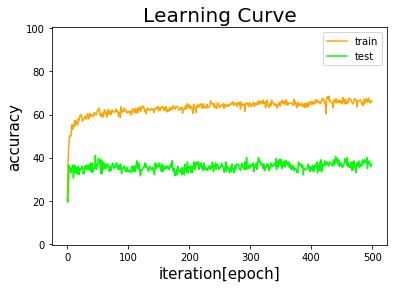

In [29]:
params = {'optimizer': 'adam',
         'batch_mode' : 'mini',
         'init': 'he',
         'lr': 0.01}

#past_train_accuracy, past_test_accuracy = model.train(X,y, params)
# model.plot_learning_curve(X,y, 'cost', params)

model.plot_learning_curve(X,y, params)

In [18]:
# model.plot_learning_curve(X,y, params)

### 提出用ファイル作成

In [22]:
test_df = pd.read_csv("test.csv")

X_sub = test_df
X_sub = np.array(X_sub)

Y_pred = model.predict(X_sub)

submission = pd.DataFrame({
       "ImageId": np.array(test_df.index) + 1,
       "Label": Y_pred
   })

submission.to_csv("./submission_002.csv", index=False)